### Import thư viện

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [2]:
df = pd.read_csv('BTC-USD.csv')
df = df.sort_values('Date').reset_index(drop=True)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.shape

(2817, 7)

### Vẽ biểu đồ giá theo giá đóng của

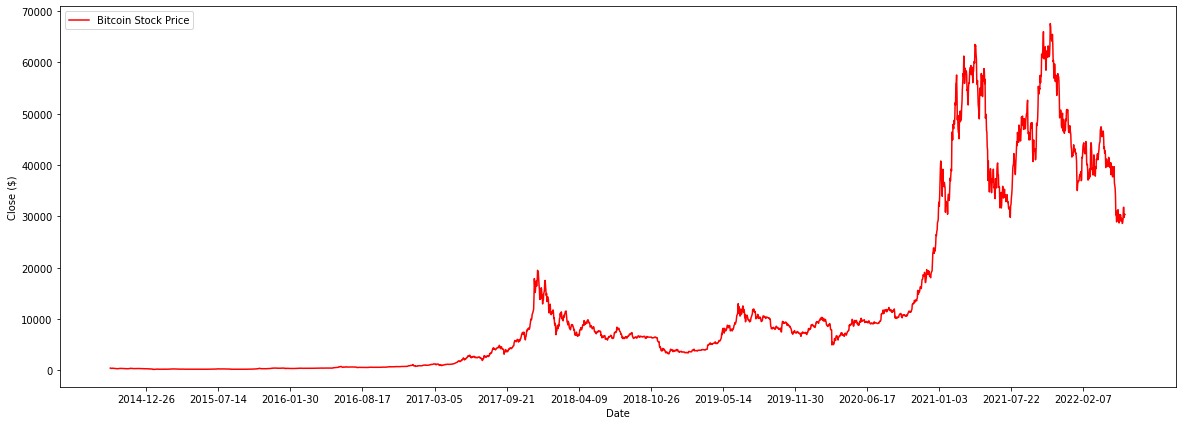

In [5]:
#giá đóng cửa
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Bitcoin Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

### Data Preprocessing

In [6]:
num_shape = 2000
train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [8]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

### Recurrent Neural Network

#### Training of the basic LSTM model

In [9]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru (GRU)                   (None, 60, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                2

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 128);

Epoch 1/100
16/16 [==============================] - 8s 174ms/step - loss: 0.0218
Epoch 2/100
16/16 [==============================] - 3s 172ms/step - loss: 0.0048
Epoch 3/100
16/16 [==============================] - 3s 175ms/step - loss: 0.0037
Epoch 4/100
16/16 [==============================] - 3s 172ms/step - loss: 0.0029
Epoch 5/100
16/16 [==============================] - 3s 177ms/step - loss: 0.0028
Epoch 6/100
16/16 [==============================] - 3s 179ms/step - loss: 0.0027
Epoch 7/100
16/16 [==============================] - 3s 205ms/step - loss: 0.0026
Epoch 8/100
16/16 [==============================] - 3s 191ms/step - loss: 0.0025
Epoch 9/100
16/16 [==============================] - 3s 213ms/step - loss: 0.0022
Epoch 10/100
16/16 [==============================] - 3s 215ms/step - loss: 0.0021
Epoch 11/100
16/16 [==============================] - 4s 247ms/step - loss: 0.0023
Epoch 12/100
16/16 [==============================] - 4s 225ms/step - loss: 0.0022
Epoch 13/100


#### Prediction

In [11]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [12]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

26/26 [==============================] - 2s 22ms/step


In [13]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 77639994.13577347
MAE: 6456.761439130699
RMSE: 8811.35597599901


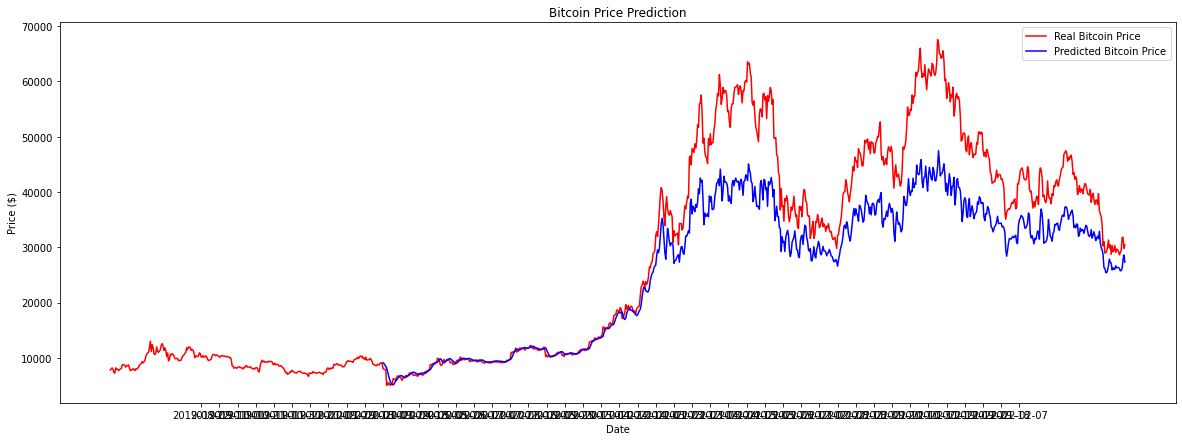

In [14]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [15]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(5):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

26/26 [==============================] - 1s 26ms/step


In [16]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [17]:
df_date = df[['Date']]

for h in range(10):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

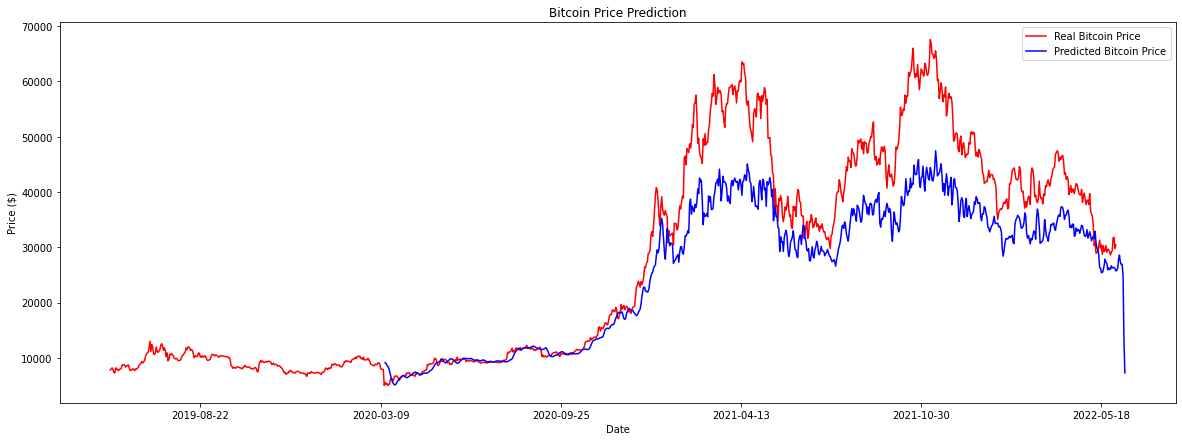

In [18]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1700:].shape[0],200))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

### GRU

In [19]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_4 (GRU)                 (None, 50)               

In [20]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
16/16 [==============================] - 8s 159ms/step - loss: 0.0240
Epoch 2/100
16/16 [==============================] - 3s 165ms/step - loss: 0.0037
Epoch 3/100
16/16 [==============================] - 3s 168ms/step - loss: 0.0027
Epoch 4/100
16/16 [==============================] - 3s 163ms/step - loss: 0.0022
Epoch 5/100
16/16 [==============================] - 3s 173ms/step - loss: 0.0022
Epoch 6/100
16/16 [==============================] - 3s 169ms/step - loss: 0.0023
Epoch 7/100
16/16 [==============================] - 3s 163ms/step - loss: 0.0020
Epoch 8/100
16/16 [==============================] - 3s 162ms/step - loss: 0.0018
Epoch 9/100
16/16 [==============================] - 3s 168ms/step - loss: 0.0018
Epoch 10/100
16/16 [==============================] - 3s 161ms/step - loss: 0.0017
Epoch 11/100
16/16 [==============================] - 3s 165ms/step - loss: 0.0014
Epoch 12/100
16/16 [==============================] - 3s 175ms/step - loss: 0.0016
Epoch 13/100


In [21]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

26/26 [==============================] - 2s 25ms/step


In [22]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 23095553.654625155
MAE: 3528.047202602853
RMSE: 4805.783354940707


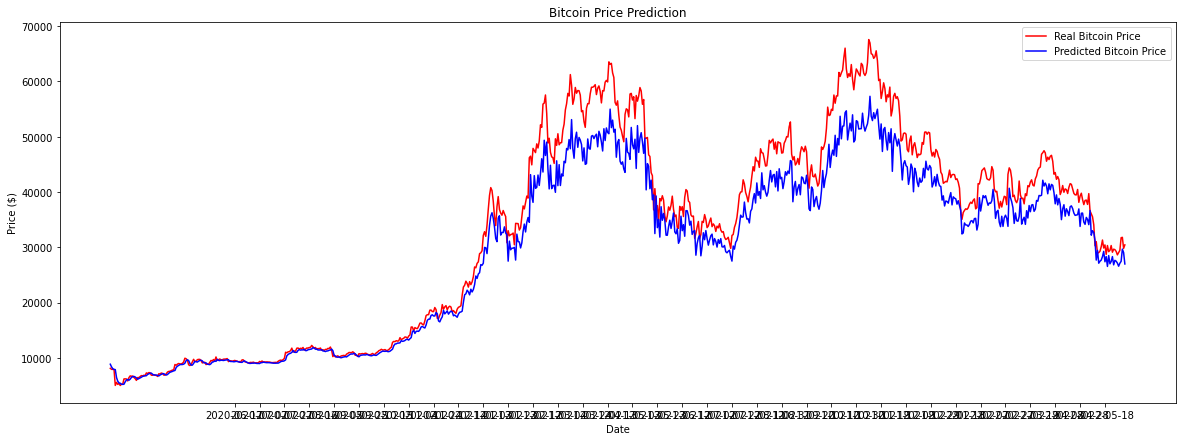

In [23]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[2000:], df_volume[2000:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[2000:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [24]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(5):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

26/26 [==============================] - 1s 24ms/step


In [25]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(5):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

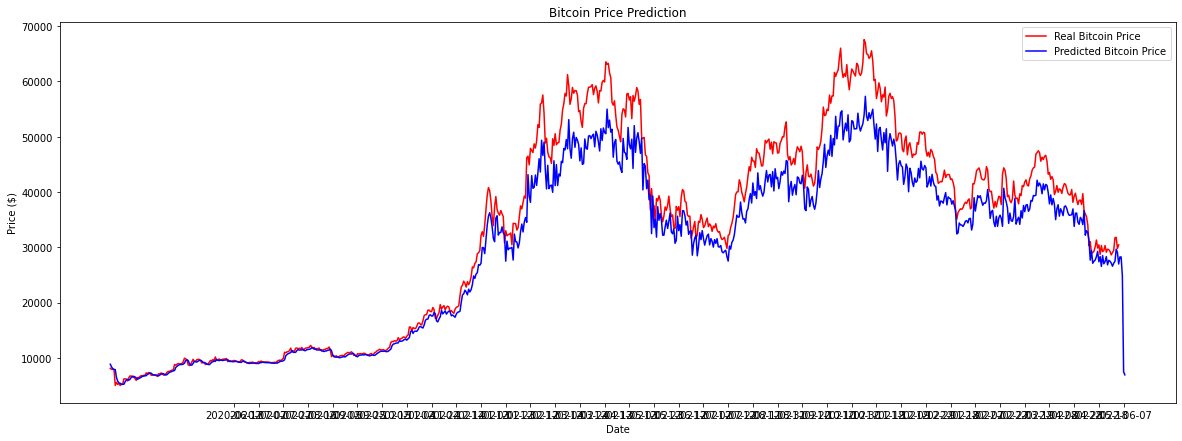

In [26]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[2000:], df_volume[2000:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df_date[2000:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()